In [1404]:
#######################################
########## IMPORTS ####################
from localLibrary_AWSConnector import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime 


from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



In [1750]:
#HELPER FUNCTIONS

#Returns dictionary of dataframes
def get_data():
    data_list = []
    data_dict = {}
    
    file_dir = os.getcwd() + '\\data\\'
    items = os.listdir(file_dir)
    
    for i in items:
        if i == 'SG_STM_purchase_date.csv' or i == 'STM_TM.csv':
            pass
        else:
            file = i.replace('.csv', '')
            data_list.append(file)

            # Save STM files as DataFrames
            data_dict[file] = pd.read_csv(file_dir + i, index_col=0)

    print(data_list)
    
    return data_dict

#Convert time helper
def _convert_time_to_int(time):
    #print(time)
    if time != time:
        return 0
    elif time == 0:
        return 0
    else:
        return int(''.join(c for c in time[:10] if c.isdigit()))

#convert date columns to int  for given df   
def convert_time_int(df):
    
    df['EarliestCRM_int'] = [_convert_time_to_int(x) for x in df['EarliestCRM']]
    df['LatestCRM_int'] = [_convert_time_to_int(x) for x in df['LatestCRM']]

    df['LatestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['LatestSeatGeekDate']]
    df['EarliestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['EarliestSeatGeekDate']]

    df['EarliestMarketo_int'] = [_convert_time_to_int(x) for x in df['EarliestMarketoDate']]
    df['LatestMarketo_int'] = [_convert_time_to_int(x) for x in df['LatestMarketoDate']]

    df['EarliestFanatics_int'] = [_convert_time_to_int(x) for x in df['EarliestFanaticsDate']]
    df['LatestFanatics_int'] = [_convert_time_to_int(x) for x in df['LatestFanaticsDate']]

    df['EarliestYinzcam_int'] = [_convert_time_to_int(x) for x in df['EarliestYinzcamDate']]
    df['LatestYinzcam_int'] = [_convert_time_to_int(x) for x in df['LatestYinzcamDate']]
    
    df['Purchase Date'] = [_convert_time_to_int(x) for x in df['Purchase Date']]
    
    return df

#Creates date difference column (latest - earliest)
def calculate_time_diff(df):
    
    df['CRM_diff'] = df['LatestCRM_int'] - df['EarliestCRM_int']
    df['SeatGeek_diff'] = df['LatestSeatGeek_int'] - df['EarliestSeatGeek_int']
    df['Marketo_diff'] = df['LatestMarketo_int'] - df['EarliestMarketo_int']
    df['Fanatics_diff'] = df['LatestFanatics_int'] - df['EarliestFanatics_int']
    df['Yinzcam_diff'] = df['LatestYinzcam_int'] - df['EarliestYinzcam_int']
    
    
    df['SeatGeek_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestSeatGeek_int'], df['Purchase Date'])]
    df['CRM_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestCRM_int'], df['Purchase Date'])]
    df['Marketo_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestMarketo_int'], df['Purchase Date'])]
    df['Fanatics_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestFanatics_int'], df['Purchase Date'])]
    df['Yinzcam_to_purchase'] = [p-s if s > 0 else p for s,p in zip(df['LatestYinzcam_int'], df['Purchase Date'])]

#     df['SeatGeek_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestSeatGeek_int'], df['Purchase Date'])]
#     df['CRM_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestCRM_int'], df['Purchase Date'])]
#     df['Marketo_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestMarketo_int'], df['Purchase Date'])]
#     df['Fanatics_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestFanatics_int'], df['Purchase Date'])]
#     df['Yinzcam_to_purchase'] = [p-s if p > 0 else 0 for s,p in zip(df['LatestYinzcam_int'], df['Purchase Date'])]
    
    return df

def calculate_day_diff(df):
    try:
        df['CRM_diff'] = (pd.to_datetime(df['LatestCRM'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestCRM'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['CRM_diff'] = 0
    try:
        df['SeatGeek_diff'] = (pd.to_datetime(df['LatestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['SeatGeek_diff'] = 0
    try:
        df['Marketo_diff'] = (pd.to_datetime(df['LatestMarketoDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestMarketoDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Marketo_diff'] = 0
    try:
        df['Fanatics_diff'] = (pd.to_datetime(df['LatestFanaticsDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestFanaticsDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Fanatics_diff'] = 0
    try:
        df['Yinzcam_diff'] = (pd.to_datetime(df['LatestYinzcamDate'], format='%Y-%m-%d %H:%M:%S', errors='raise') - pd.to_datetime(df['EarliestYinzcamDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Yinzcam_diff'] = 0
    
    try:
        df['SeatGeek_to_purchase'] = (pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['SeatGeek_to_purchase'] = 9999
    try:
        df['CRM_to_purchase'] = (pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestCRM'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['CRM_to_purchase'] = 9999
    try:
        df['Marketo_to_purchase'] = (pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestMarketoDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Marketo_to_purchase'] = 9999
    try:
        df['Fanatics_to_purchase'] = (pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestFanaticsDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Fanatics_to_purchase'] = 9999
    try:
        df['Yinzcam_to_purchase'] = (pd.to_datetime(df['Purchase Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df['LatestYinzcamDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)
    except:
        df['Yinzcam_to_purchase'] = 9999
    
    df['SeatGeek_to_purchase'] = df['SeatGeek_to_purchase'].fillna(9999)
    df['CRM_to_purchase'] = df['CRM_to_purchase'].fillna(9999)
    df['Marketo_to_purchase'] = df['Marketo_to_purchase'].fillna(9999)
    df['Fanatics_to_purchase'] = df['Fanatics_to_purchase'].fillna(9999)
    df['Yinzcam_to_purchase'] = df['Yinzcam_to_purchase'].fillna(9999)

        
    return df



In [4]:
all_data = get_data()

['CRM_lost', 'CRM_nonSTM', 'CRM_STM', 'FTS_lost', 'FTS_nonSTM', 'FTS_STM', 'MK_lost', 'MK_nonSTM', 'MK_STM', 'SG_lost', 'SG_nonSTM', 'SG_STM', 'YZ_lost', 'YZ_nonSTM', 'YZ_STM']


In [5]:
archived_data = all_data.copy()

In [6]:

for key in all_data.keys():
    #SEATGEEK PIVOT
    if 'SG' in key:
        pivoted = pd.pivot_table(all_data[key], 
                         values=['TotalSeatGeekTransactions','TotalTicketVolume','TotalScannedTicketVolume','TotalTicketDollarValue'], 
                         index=['SSB_CRMSYSTEM_CONTACT_ID'],
                         columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], 
                         aggfunc=(np.sum), 
                         fill_value=0)
        #pivoted.columns = [' '.join(col).strip() for col in pivoted.columns.values]
        pivoted = pd.DataFrame(pivoted.to_records())

        pivoted_agg = pd.DataFrame()
        pivoted_agg['SSB_CRMSYSTEM_CONTACT_ID'] = pivoted['SSB_CRMSYSTEM_CONTACT_ID']
        pivoted_agg['total_scanned'] = pivoted["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + pivoted["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + pivoted["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

        pivoted_agg['primary_purchase_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + pivoted["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

        pivoted_agg['primary_purchase_dollars'] = pivoted["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_dollars'] = pivoted["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + pivoted["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_dollars'] = pivoted["('TotalTicketDollarValue', 'Sell', 'Resale')"] + pivoted["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

        pivoted_agg['primary_purchase_tickets'] = pivoted["('TotalTicketVolume', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_tickets'] = pivoted["('TotalTicketVolume', 'Purchase', 'Resale')"] + pivoted["('TotalTicketVolume', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_tickets'] = pivoted["('TotalTicketVolume', 'Sell', 'Resale')"] + pivoted["('TotalTicketVolume', 'Sell', 'Transfer')"]

        min_dates = all_data[key]['EarliestSeatGeekDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).min()
        max_dates = all_data[key]['LatestSeatGeekDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).max()
        pivoted_agg = pivoted_agg.merge(min_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        pivoted_agg = pivoted_agg.merge(max_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        all_data[key] = pivoted_agg
        
    #MARKETO PIVOT
    if 'MK' in key:
        pivoted = pd.pivot_table(all_data[key], 
                         values=['TotalMarketoVolume'], 
                         index=['SSB_CRMSYSTEM_CONTACT_ID'],
                         columns=['cjmktActivityType'], 
                         aggfunc=(np.sum), 
                         fill_value=0)

        pivoted.columns = pivoted.columns.droplevel(0)
        min_dates = all_data[key]['EarliestMarketoDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).min()
        max_dates = all_data[key]['LatestMarketoDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).max()
        pivoted = pivoted.merge(min_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        pivoted = pivoted.merge(max_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        all_data[key] = pivoted


In [7]:
stm_purchase = pd.read_csv('./data/SG_STM_purchase_date.csv', header = None)
stm_purchase.columns = ['SSB_CRMSYSTEM_CONTACT_ID', 'Purchase Date']
all_data['SG_STM'] = stm_purchase.merge(all_data['SG_STM'], how = 'left', on = 'SSB_CRMSYSTEM_CONTACT_ID').fillna(0)

In [1751]:
#MERGE all DF for STM  
STM = None
nonSTM = None
lost = None
for key in all_data.keys():
    df = all_data[key]
    if('STM' in key and 'non' not in key): 
        if STM is None:
            STM = df
        else:
            STM = STM.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')

    elif('non' in key): 
        if nonSTM is None:
            nonSTM = df
        else:
            nonSTM = nonSTM.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('lost' in key): 
        if lost is None:
            lost = df
        else:
            lost = lost.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')            

In [1685]:
# #CONVERT DATE COLUMNS TO INT
# nonSTM['Purchase Date'] = datetime.datetime.now().strftime('%Y-%m-%d')
# lost['Purchase Date'] = datetime.datetime.now().strftime('%Y-%m-%d')

# STM = convert_time_int(STM)
# nonSTM = convert_time_int(nonSTM)
# lost = convert_time_int(lost)



# #filter records from lost where marketo + crm + sg are over a year old
# # lost[lost['']]

# # #CALCULATE DATE DIFFERENCE
# # #QUANTIFY LENGTH OF ENGAGEMENT

# STM = calculate_time_diff(STM)
# nonSTM = calculate_time_diff(nonSTM)
# lost = calculate_time_diff(lost)


In [1752]:
#CALC DATE DIFF
nonSTM['Purchase Date'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
lost['Purchase Date'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')


STM = calculate_day_diff(STM)
nonSTM = calculate_day_diff(nonSTM)
lost = calculate_day_diff(lost)


In [1727]:
df = lost


In [1723]:
df[(df['SSB_CRMSYSTEM_CONTACT_ID'] =='702DBA63-B35D-4D77-962F-CB94C90B896A')][['SeatGeek_to_purchase', 'Purchase Date', 'EarliestSeatGeekDate', 'LatestSeatGeekDate', 'secondary_sell_transactions']]


# (pd.to_datetime(df[(df['SSB_CRMSYSTEM_CONTACT_ID'] =='702DBA63-B35D-4D77-962F-CB94C90B896A')][ 'Purchase Date']
# , format='%Y-%m-%d %H:%M:%S.%f', errors='raise') - pd.to_datetime(df[(df['SSB_CRMSYSTEM_CONTACT_ID'] =='702DBA63-B35D-4D77-962F-CB94C90B896A')]['LatestSeatGeekDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')).apply(lambda x: x.days)


2   NaN
dtype: float64

In [1720]:
pd.to_datetime(df[(df['SSB_CRMSYSTEM_CONTACT_ID'] =='702DBA63-B35D-4D77-962F-CB94C90B896A')][[ 'Purchase Date']].stack(), format='%Y-%m-%d %H:%M:%S.%f', errors='ignore').unstack()

,Purchase Date
2,2020-10-30 11:27:17.534660


In [1722]:
pd.to_datetime(df[(df['SSB_CRMSYSTEM_CONTACT_ID'] =='702DBA63-B35D-4D77-962F-CB94C90B896A')][ 'Purchase Date'], format='%Y-%m-%d %H:%M:%S.%f', errors='raise')

2   2020-10-30 11:27:17.534660
Name: Purchase Date, dtype: datetime64[ns]

In [1753]:
#DROP DATE COLUMNS
for col in STM.columns:
    if 'Date' in col:
#         if col =='Purchase Date':
#             pass
#         else:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif '_int' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    
    else:
        pass

STM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
nonSTM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
lost.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True) 

# STM.drop(['Purchase Date'], axis=1, inplace = True)
# nonSTM.drop(['Purchase Date'], axis=1, inplace = True)
# lost.drop(['Purchase Date'], axis=1, inplace = True) 

EarliestFanaticsDate
LatestFanaticsDate
EarliestMarketoDate
LatestMarketoDate
Purchase Date
EarliestSeatGeekDate
LatestSeatGeekDate
EarliestYinzcamDate
LatestYinzcamDate


In [ ]:
print(f"STM Length: {len(STM)}")
print(f"nonSTM Length: {len(nonSTM)}")
print(f"lost Length: {len(lost)}")


In [1564]:
#Get percent null in each column across the merged datasets
stm_null = pd.DataFrame(STM.isna().sum()/len(STM), columns = ['STM_Pct_Null'])
nonstm_null = pd.DataFrame(nonSTM.isna().sum()/len(nonSTM), columns = ['nonSTM_Pct_Null'])
lost_null = pd.DataFrame(lost.isna().sum()/len(lost), columns = ['lost_Pct_Null'])

all_null = stm_null.merge(nonstm_null.merge(lost_null, left_index=True, right_index=True), left_index=True, right_index=True)


In [1565]:
all_null.sort_values(by = 'STM_Pct_Null', ascending = True)

,STM_Pct_Null,nonSTM_Pct_Null,lost_Pct_Null
SSB_CRMSYSTEM_CONTACT_ID,0.000000,0.000000,0.000000
SeatGeek_to_purchase,0.000000,0.945265,0.813998
SeatGeek_diff,0.000000,0.945265,0.813998
secondary_sell_tickets,0.000000,0.945265,0.813998
secondary_purchase_tickets,0.000000,0.945265,0.813998
primary_purchase_tickets,0.000000,0.945265,0.813998
secondary_sell_dollars,0.000000,0.945265,0.813998
secondary_purchase_dollars,0.000000,0.945265,0.813998
primary_purchase_dollars,0.000000,0.945265,0.813998
secondary_sell_transactions,0.000000,0.945265,0.813998


In [1754]:
STM = STM.fillna(0)
nonSTM = nonSTM.fillna(0)
lost = lost.fillna(0)

for c in lost.columns.values:
    if 'zz' in c:
        print(c)
        lost.drop([c], axis = 0, inplace = True)
    if 'Group Form' in c:
        lost.drop([c], axis = 1, inplace = True)


In [1755]:
#EXCLUDE RENEWALS
stm_purchase = pd.read_csv('./data/STM_TM.csv')
STM = pd.merge(STM, stm_purchase, left_on='SSB_CRMSYSTEM_CONTACT_ID',right_on = 'SSB_Composite_Record_Unique_ID', how="outer", indicator=True
              ).query('_merge=="left_only"')
nonSTM = pd.merge(nonSTM, stm_purchase, left_on='SSB_CRMSYSTEM_CONTACT_ID',right_on = 'SSB_Composite_Record_Unique_ID', how="outer", indicator=True
              ).query('_merge=="left_only"')
lost = pd.merge(lost, stm_purchase, left_on='SSB_CRMSYSTEM_CONTACT_ID',right_on = 'SSB_Composite_Record_Unique_ID', how="outer", indicator=True
              ).query('_merge=="left_only"')

In [1756]:
#STACK STM NONSTM, LOST

STM['target'] = '1'
lost['target'] = '0'
nonSTM['target'] = 'nonSTM'

full_data = pd.concat([STM, lost])
full_data.drop(['acct_id', 'SSB_Composite_Record_Unique_ID', '_merge' ], axis = 1, inplace = True)

In [64]:
full_data['target'].value_counts()/ len(full_data['target'])

0    0.975725
1    0.024275
Name: target, dtype: float64

In [1603]:
c = full_data.drop(['SSB_CRMSYSTEM_CONTACT_ID'], axis = 1).astype('float').corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending = False)
so[so > .8 ][so < 1]

TotalFanaticsTransactions        TotalFanaticsProductQty            0.979092
TotalFanaticsProductQty          TotalFanaticsTransactions          0.979092
secondary_sell_transactions      secondary_sell_tickets             0.956997
secondary_sell_tickets           secondary_sell_transactions        0.956997
secondary_purchase_tickets       secondary_purchase_transactions    0.940493
secondary_purchase_transactions  secondary_purchase_tickets         0.940493
primary_purchase_tickets         total_scanned                      0.914763
total_scanned                    primary_purchase_tickets           0.914763
TotalFanaticsTransactions        TotalFanaticsDollarValue           0.892782
TotalFanaticsDollarValue         TotalFanaticsTransactions          0.892782
                                 TotalFanaticsProductQty            0.871454
TotalFanaticsProductQty          TotalFanaticsDollarValue           0.871454
secondary_sell_dollars           secondary_purchase_dollars         0.867071

In [1604]:
pd.DataFrame(c['target'].sort_values())

,target
Lead-Gen,0.000309
Contest,0.000994
secondary_purchase_tickets,0.001339
Fanatics_diff,0.001563
secondary_purchase_dollars,0.001990
Click Link,0.002700
Visit Webpage,0.002792
secondary_purchase_transactions,0.002851
Suite & Premium Inquiry Form,0.002872
secondary_sell_dollars,0.003884


In [1575]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
min_variance = .1
df = full_data.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1)
low_variance = variance_threshold_selector(df ,min_variance) 
print('columns removed:')
dropped_cols = (df.columns ^ low_variance.columns).values
print(dropped_cols)


columns removed:
['CRM Sync' 'Fanatics' 'Form Submission' 'Lead-Gen' 'List Import'
 'Received Forward to Friend Email' 'Sent Forward to Friend Email'
 'Suite & Premium Inquiry Form']


In [1757]:
#dropped based on minimam variance
#dropped = full_data.drop(dropped_cols, axis = 1)
# #dropped based on multi collinearity
# dropped.drop(['secondary_sell_transactions'], axis = 1, inplace = True)

#iterative dropping based on p values


#Final iteraive dropped
# dropped.drop(['Fanatics_to_purchase', 'secondary_sell_dollars', 'primary_purchase_dollars', 'Yinzcam_diff', 
#               'Fill Out Form', 'TotalCRMActivityVolume', 'secondary_sell_tickets', 'TotalFanaticsDollarValue', 
#               'Yinzcam_to_purchase', 'Fanatics_diff', 'primary_purchase_tickets', 'Open Email', 'TotalYinzcamVolume',
#               'Click Email',
#               'Marketo_to_purchase', 'total_scanned', 'Click Link'
#             ],axis = 1, inplace = True)



dropped = full_data

In [1758]:
import sklearn.preprocessing as sk

sampled = dropped.sample(frac=1)

X = sampled.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1)
y = sampled['target']
label_encoder = sk.LabelEncoder().fit(y)
y = label_encoder.transform(y)

In [1272]:
# copy_X = X.copy()
# copy_y = y.copy()

In [1273]:
# import statsmodels.api as sm
# logit_model=sm.Logit(y,X.astype(float)).fit_regularized()
# #result=logit_model.fit()
# print(logit_model.summary())

In [1734]:
def train_and_predict(X_train, y_train, X_test, y_test):
    #model = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, y_train)
    #model = RandomForestClassifier(max_depth=4, random_state=0).fit(X_train, y_train)
    model = DecisionTreeClassifier(max_depth=5, random_state=0).fit(X_train, y_train)

    #preds = (model.predict_proba(X_test)[:,1] >= .5).astype(bool)
    preds = model.predict(X_test)

    
    roc_score = roc_auc_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    print(roc_score)
    print(precision)
    print(recall)
    return (roc_score, recall, precision)

In [1480]:
# from imblearn.under_sampling import NearMiss
# undersample = NearMiss(version=2, n_neighbors=5)


In [1759]:
X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
X_use, X_val, y_use, y_val = train_test_split(X_use, y_use, stratify=y_use, test_size=.1, random_state = 23)

kf = StratifiedKFold(n_splits=5) # Define the split - into 5 folds 
roc = 0
prec = 0
rec = 0
for train_index, test_index in kf.split(X_use, y_use):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_use.iloc[train_index], X_use.iloc[test_index]
    y_train, y_test = y_use[train_index], y_use[test_index]
    
    #X_train, y_train = undersample.fit_resample(X_train, y_train)
    
    ro,re,p = train_and_predict(X_train, y_train, X_test, y_test)
    roc += ro
    prec += p
    rec += re

TRAIN: [14134 14135 14136 ... 70701 70702 70703] TEST: [    0     1     2 ... 14269 14279 14284]
0.9882294810123747
0.9911242603550295
0.9766763848396501
TRAIN: [    0     1     2 ... 70701 70702 70703] TEST: [14134 14135 14136 ... 28293 28294 28295]
0.9923489989042228
0.9712643678160919
0.9854227405247813
TRAIN: [    0     1     2 ... 70701 70702 70703] TEST: [27687 27715 27759 ... 42425 42426 42427]
0.9969033624258724
0.9855491329479769
0.9941690962099126
TRAIN: [    0     1     2 ... 70701 70702 70703] TEST: [42206 42239 42271 ... 57108 57109 57122]
0.9939686079380249
0.9826589595375722
0.9883720930232558
TRAIN: [    0     1     2 ... 57108 57109 57122] TEST: [56551 56552 56553 ... 70701 70702 70703]
0.9908912466921971
0.9711815561959655
0.9825072886297376


In [1760]:
roc/5

0.9924683393945385

In [1761]:
prec/5

0.9803556553705273

In [1762]:
rec/5

0.9854295206454676

In [1763]:
#log = LogisticRegression(penalty='l1', solver='saga').fit(X_use, y_use)
#clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_use, y_use)
clf = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_use, y_use)

preds = clf.predict(X_holdout)
preds_proba = clf.predict_proba(X_holdout)

In [1764]:
roc_score = roc_auc_score(y_holdout, preds)
recall = recall_score(y_holdout, preds)
precision = precision_score(y_holdout, preds)
r2 = r2_score(y_holdout,preds)
print(roc_score)
print(recall)
print(precision)
print(r2)

0.9904486255014943
0.9811320754716981
0.9904761904761905
0.9709936398014183


In [1765]:
preds = clf.predict(X_val)
preds_proba = clf.predict_proba(X_val)

In [1766]:
roc_score = roc_auc_score(y_val, preds)
recall = recall_score(y_val, preds)
precision = precision_score(y_val, preds)
r2 = r2_score(y_val,preds)
print(roc_score)
print(recall)
print(precision)
print(r2)

0.9946991748428842
0.9895287958115183
0.9947368421052631
0.9839018553400273


In [1767]:
preds.mean()

0.024182257859233804

In [1768]:
y_holdout.mean()

0.02428685989231298

In [1769]:
pd.DataFrame([X.columns.values, clf.feature_importances_]).T.sort_values(by=1, ascending = False)


,0,1
40,SeatGeek_to_purchase,0.932733
36,SeatGeek_diff,0.0293273
42,Marketo_to_purchase,0.0250905
41,CRM_to_purchase,0.00796176
37,Marketo_diff,0.00488794
0,TotalCRMActivityVolume,0
31,primary_purchase_tickets,0
25,primary_purchase_transactions,0
26,secondary_purchase_transactions,0
27,secondary_sell_transactions,0


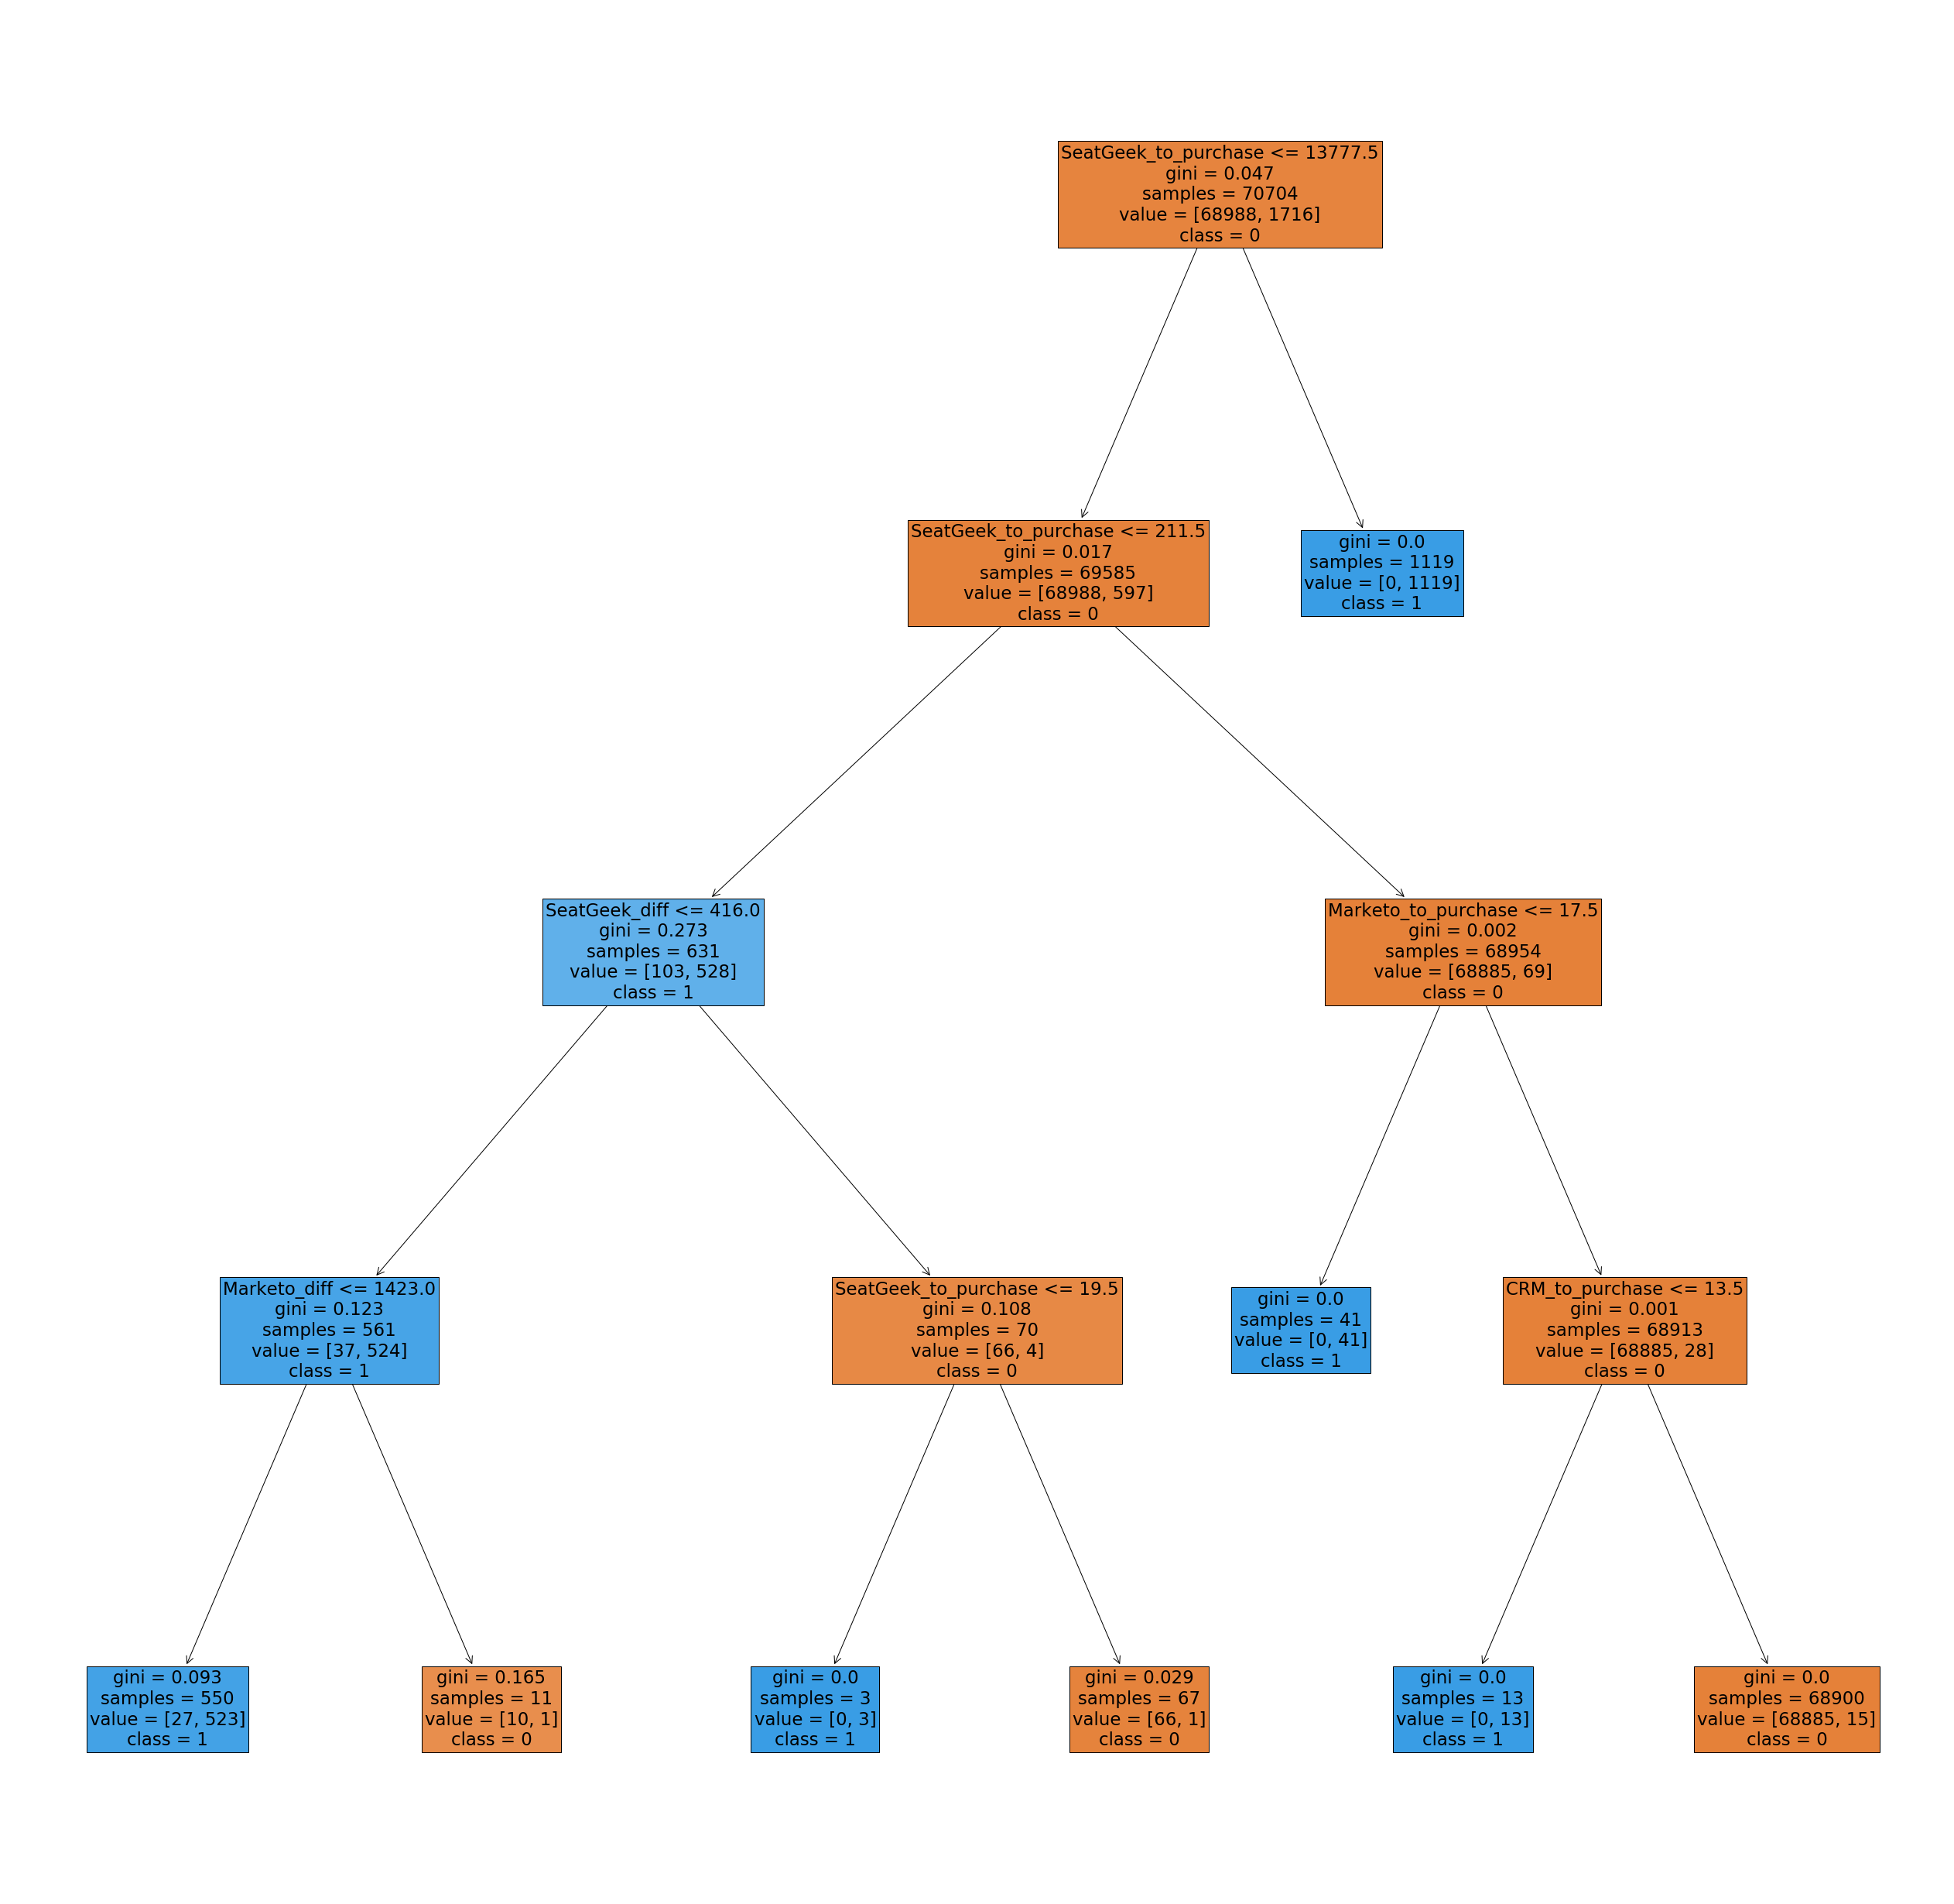

In [1771]:
from sklearn import tree

fig = plt.figure(figsize=(45,45))
plt.rcParams.update({'font.size': 22})
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names=['0', '1'],
                   filled=True)



In [1460]:
y_use.mean()

0.02427413093010527

In [1348]:
from scipy.stats import norm
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

pvalues = logit_pvalue(log, X_holdout.astype(float))[1:]


In [1349]:
coefs = log.coef_[0]

In [1350]:
pd.DataFrame([X.columns.values, coefs, pvalues]).T

,0,1,2
0,TotalCRMActivityVolume,-3.78294e-09,1
1,Click Email,-5.7469e-09,0.999998
2,Click Link,-1.29156e-09,1
3,Contest,-1.01447e-09,1
4,Fill Out Form,-1.62096e-09,1
5,Open Email,-2.66551e-08,0.999983
6,Visit Webpage,-2.79641e-09,1
7,primary_purchase_dollars,-2.20794e-07,0.997949
8,secondary_sell_dollars,-3.03182e-08,0.999909
9,primary_purchase_tickets,-2.89423e-09,0.999999


In [1023]:
log.intercept_

array([-3.85070435])

In [897]:
np.sqrt(.55)

0.7416198487095663

In [1647]:
hist_df = pd.DataFrame(preds_proba)
hist_df['actual'] = y_val
hist_df['rounded_pred_proba'] = hist_df[1].apply(lambda x: round(x, 1))
#pct = hist_df.groupby(by = ['rounded'], as_index = False).mean()[['rounded','actual']]
pos = hist_df.groupby(by = ['rounded_pred_proba'], as_index = False).sum()[['rounded_pred_proba','actual']]
tot = hist_df.groupby(by = ['rounded_pred_proba'], as_index = False).count()[['rounded_pred_proba','actual']]
tot['actual_pos_pct'] = pos['actual']/tot['actual']

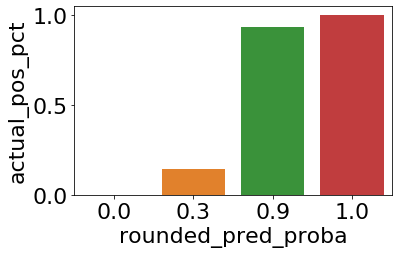

In [1648]:
fig, ax1 = plt.subplots()

# ax2 = ax1.twinx()

sns.barplot(x="rounded_pred_proba", y="actual_pos_pct", data=tot, ax = ax1, alpha = 1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped



In [836]:
len(nonSTM_preds)

1467993

In [837]:
sum(nonSTM_preds)

12233

In [883]:
X.columns

Index(['Click Email', 'Contest', 'Fill Out Form', 'Visit Webpage',
       'primary_purchase_transactions', 'secondary_purchase_dollars',
       'secondary_purchase_tickets', 'CRM_diff', 'SeatGeek_diff',
       'Marketo_diff', 'SeatGeek_to_purchase', 'CRM_to_purchase',
       'Marketo_to_purchase'],
      dtype='object')

In [931]:
pred_interpret = nonSTM[['SSB_CRMSYSTEM_CONTACT_ID']+list(X.columns)].copy()

In [932]:
pred_interpret['Click Email'] = pred_interpret['Click Email'] * 0.00748428
pred_interpret['Contest'] = pred_interpret['Contest'] * 0.00748428
pred_interpret['Fill Out Form'] = pred_interpret['Fill Out Form'] * 0.00748428
pred_interpret['Click Email'] = pred_interpret['Click Email'] * 0.00748428
pred_interpret['Click Email'] = pred_interpret['Click Email'] * 0.00748428


In [910]:
i = 0
for c in list(X.columns):
    pred_interpret[c] = pred_interpret[c] * coefs[i]
    i += 1 

In [933]:
pred_interpret.columns

Index(['SSB_CRMSYSTEM_CONTACT_ID', 'Click Email', 'Contest', 'Fill Out Form',
       'Visit Webpage', 'primary_purchase_transactions',
       'secondary_purchase_dollars', 'secondary_purchase_tickets', 'CRM_diff',
       'SeatGeek_diff', 'Marketo_diff', 'SeatGeek_to_purchase',
       'CRM_to_purchase', 'Marketo_to_purchase'],
      dtype='object')

In [934]:
pred_interpret = pred_interpret.set_index('SSB_CRMSYSTEM_CONTACT_ID')
max_pred_interpret_feat = pd.DataFrame(pred_interpret.columns.values[np.argsort(-pred_interpret.values, axis=1)[:, :3]], 
                  index=pred_interpret.index,
                  columns = ['1st Max','2nd Max','3rd Max']).reset_index()
min_pred_interpret_feat = pd.DataFrame(pred_interpret.columns.values[np.argsort(pred_interpret.values, axis=1)[:, :3]], 
                  index=pred_interpret.index,
                  columns = ['1st Min','2nd Min','3rd Min']).reset_index()

In [935]:
min_pred_interpret_feat

,SSB_CRMSYSTEM_CONTACT_ID,1st Min,2nd Min,3rd Min
0,0000005C-1547-495D-90BE-FCF954C5B34C,CRM_to_purchase,Click Email,Contest
1,0000081B-6356-47EF-869D-F715CD0F6C75,Marketo_to_purchase,CRM_to_purchase,Click Email
2,00002EC0-E23E-4D0A-A0D5-D91FA396D24B,CRM_to_purchase,Click Email,Contest
3,00006B60-3150-45DD-AB5C-D83088789C4A,CRM_to_purchase,Click Email,Contest
4,00007011-65C0-4C50-86D4-23037625D448,CRM_to_purchase,Click Email,Contest
...,...,...,...,...
1467988,73D65470-7942-4988-BF05-4E20EFA4E2C3,Click Email,Contest,Fill Out Form
1467989,FA892F74-D2E1-4F5C-8AF2-04D566DF7AD2,Click Email,Contest,Fill Out Form
1467990,AE55553E-6CF3-4DF9-8D1A-E1CA2398A8E6,Click Email,Contest,Fill Out Form
1467991,123EB4DF-EAEF-487A-95BB-FF572E998142,Click Email,Contest,Fill Out Form


In [936]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [1351]:
calc_vif(X)

,variables,VIF
0,TotalCRMActivityVolume,1.767538
1,Click Email,1.226052
2,Click Link,1.512162
3,Contest,1.241126
4,Fill Out Form,1.378656
5,Open Email,1.899074
6,Visit Webpage,1.520787
7,primary_purchase_dollars,1.594251
8,secondary_sell_dollars,1.831779
9,primary_purchase_tickets,1.517424


In [1027]:
c = X.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending = False)
so[so < 1]

CRM_to_purchase       Marketo_to_purchase           0.496555
Marketo_to_purchase   CRM_to_purchase               0.496555
                      Marketo_diff                  0.383369
Marketo_diff          Marketo_to_purchase           0.383369
SeatGeek_diff         secondary_purchase_tickets    0.354199
                                                      ...   
Click Email           SeatGeek_to_purchase          0.001732
Visit Webpage         Marketo_to_purchase           0.000950
Marketo_to_purchase   Visit Webpage                 0.000950
SeatGeek_to_purchase  Fill Out Form                 0.000211
Fill Out Form         SeatGeek_to_purchase          0.000211
Length: 132, dtype: float64

In [1776]:
nonSTM_preds = clf.predict_proba(nonSTM[X.columns])

In [1777]:
nonSTM_preds.mean()

0.49999999999999994

In [1780]:
hist_df = pd.DataFrame(nonSTM_preds)
hist_df['rounded_pred_proba'] = hist_df[1].apply(lambda x: round(x, 1))
pos = hist_df.groupby(by = ['rounded_pred_proba'], as_index = False).sum()

# fig, ax1 = plt.subplots()

# # ax2 = ax1.twinx()

# sns.barplot(x="rounded_pred_proba", y="actual_pos_pct", data=tot, ax = ax1, alpha = 1)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped


In [1781]:
pos

,rounded_pred_proba,0,1
0,0.0,1.467079e+06,329.554408
1,0.1,8.545455e+01,8.545455
2,1.0,2.405455e+01,465.945455
